## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

# from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-07-07 22:01:00.490241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 22:01:00.490339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 22:01:00.660132: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Extract Image Features

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1720389683.083076     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

## Preprocess Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

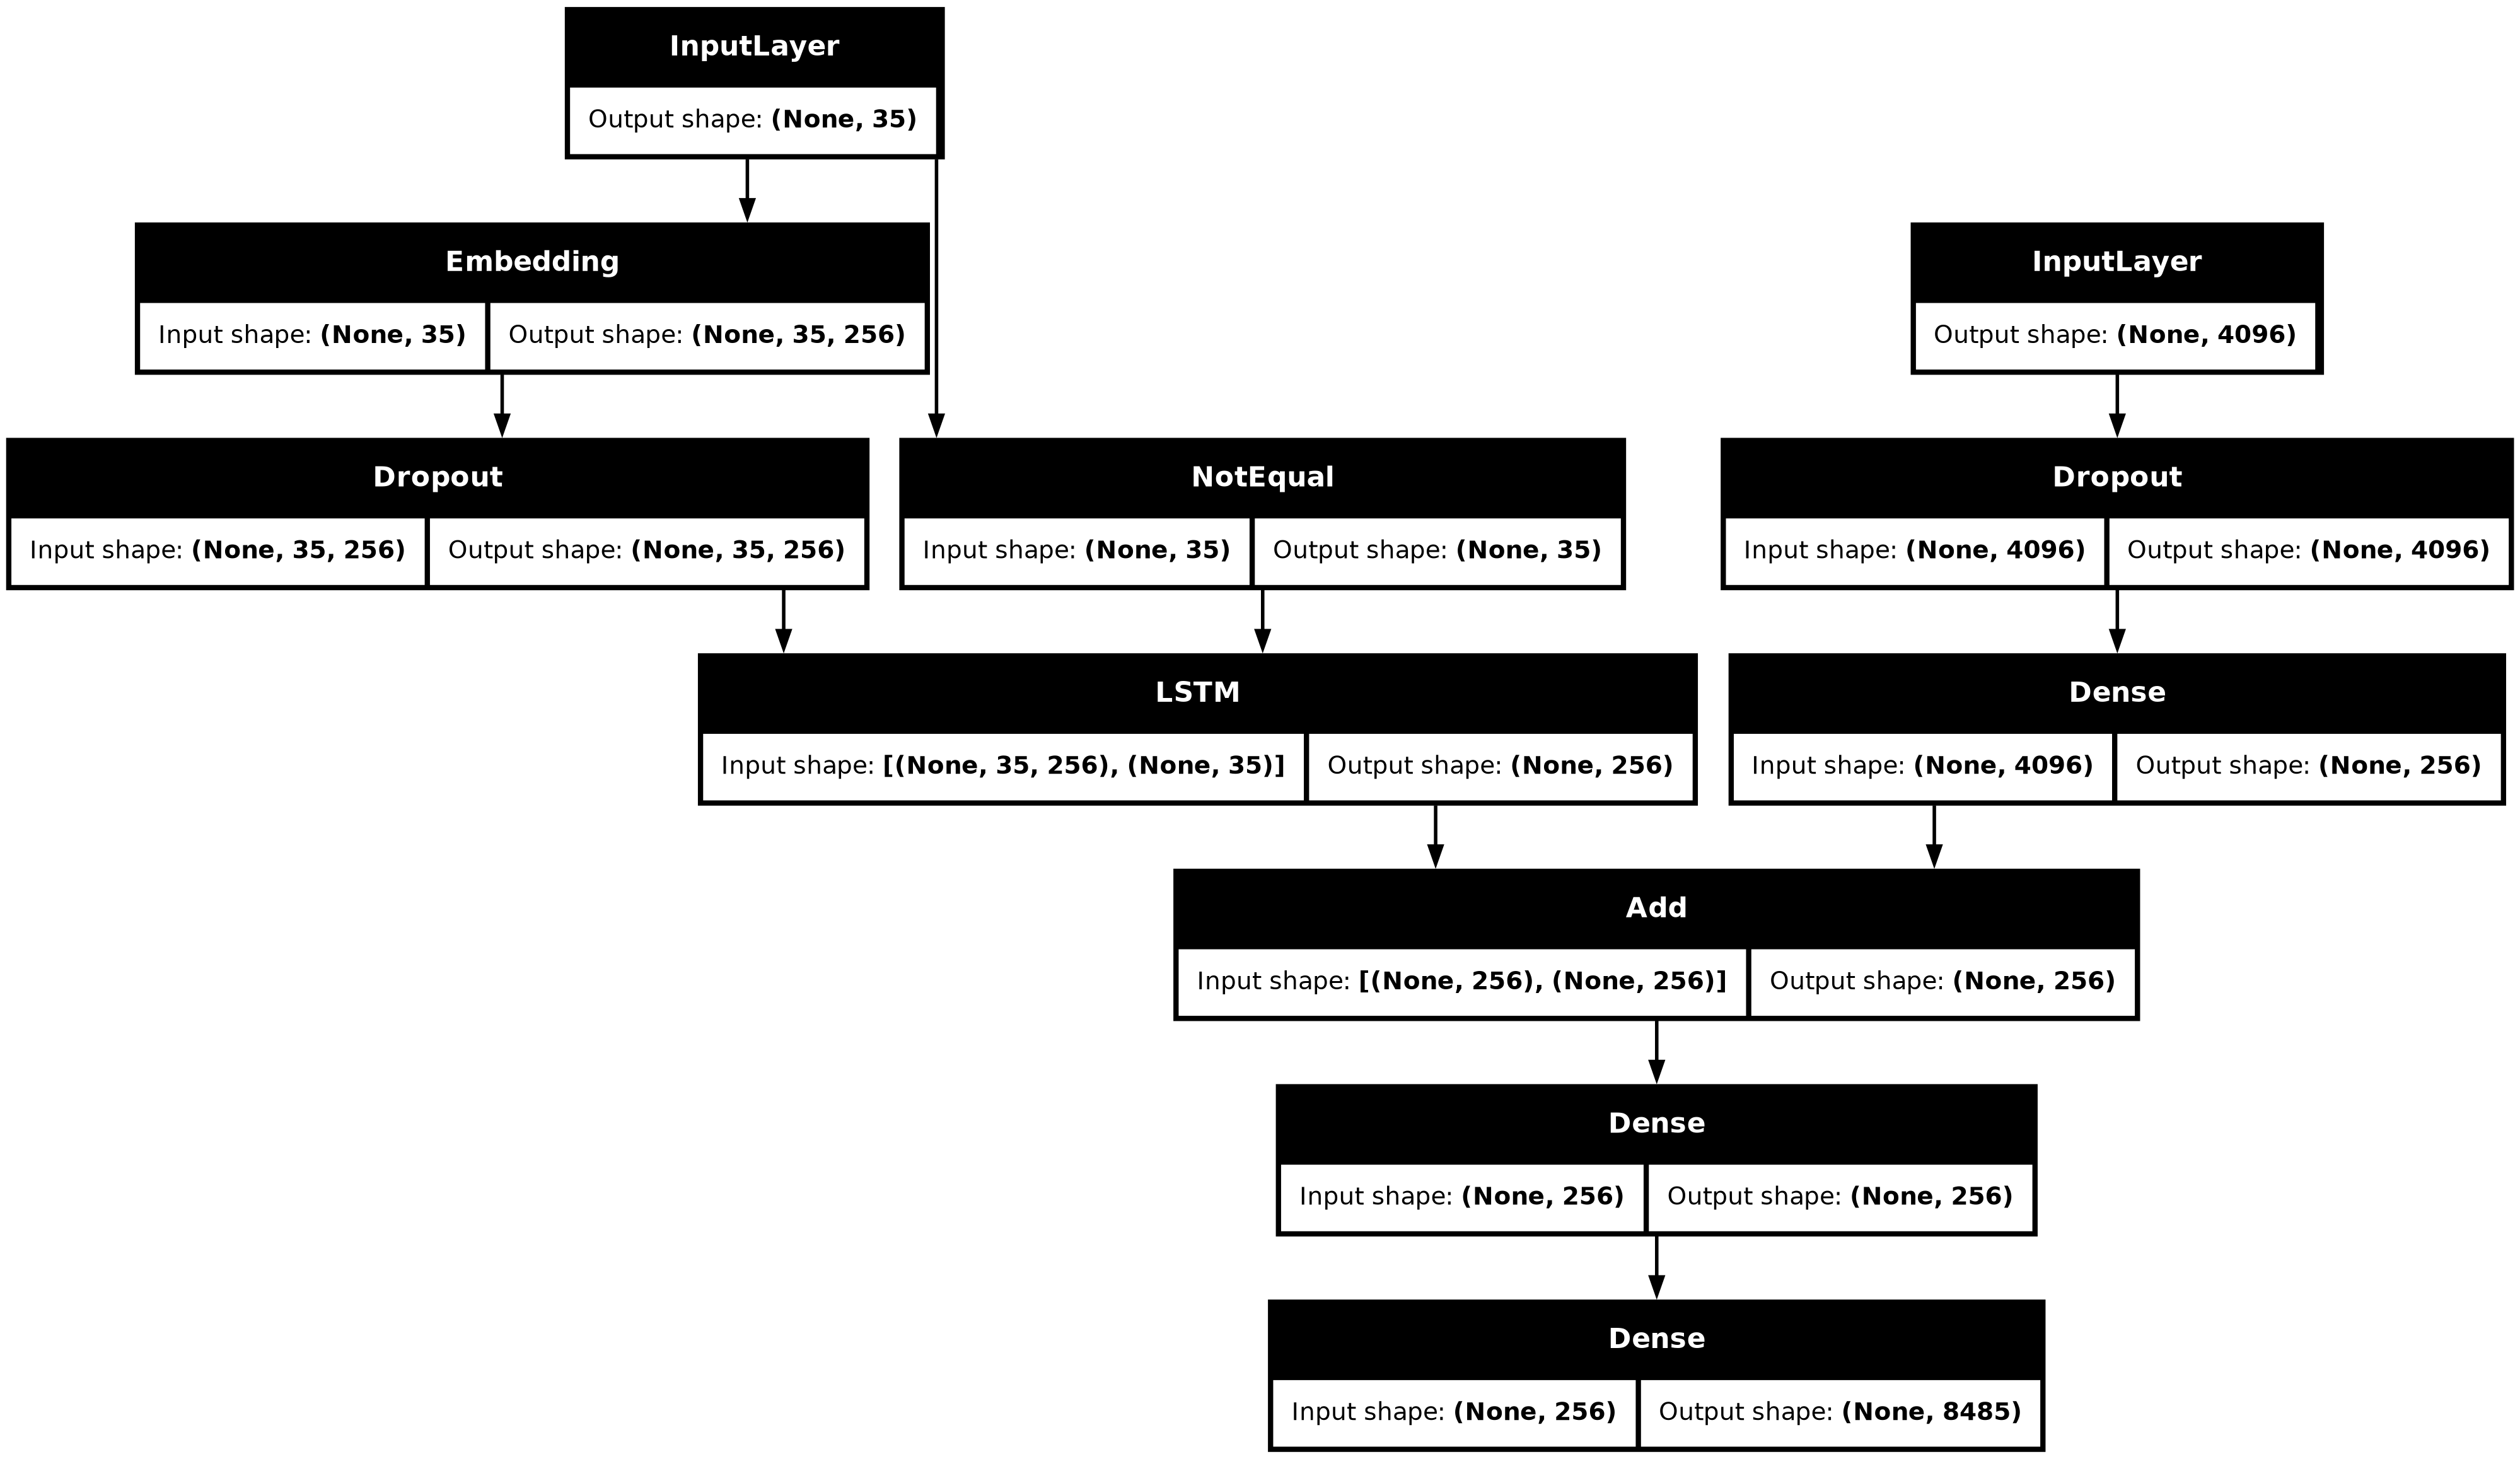

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
# inputs1 = Input(shape=(1920,), name="image")
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [23]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  1/227 ━━━━━━━━━━━━━━━━━━━━ 26:37 7s/step - loss: 9.0604

W0000 00:00:1720390322.385195     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390322.441418     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390322.504537     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/227 ━━━━━━━━━━━━━━━━━━━━ 16:30 4s/step - loss: 8.9542

W0000 00:00:1720390326.777294     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390326.780350     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390326.834492     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390326.908265     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/227 ━━━━━━━━━━━━━━━━━━━━ 16:23 4s/step - loss: 8.8025

W0000 00:00:1720390331.164100     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390331.213755     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390331.282023     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/227 ━━━━━━━━━━━━━━━━━━━━ 16:38 4s/step - loss: 8.6198

W0000 00:00:1720390335.820043     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390335.875545     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390335.938564     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/227 ━━━━━━━━━━━━━━━━━━━━ 16:40 5s/step - loss: 8.4638

W0000 00:00:1720390340.403815     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390340.406802     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390340.461122     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390340.531100     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/227 ━━━━━━━━━━━━━━━━━━━━ 13:54 4s/step - loss: 8.1854

W0000 00:00:1720390345.152212     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390345.208569     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390345.272936     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/227 ━━━━━━━━━━━━━━━━━━━━ 14:10 4s/step - loss: 8.0678

W0000 00:00:1720390349.576344     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390349.631770     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390349.694701     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/227 ━━━━━━━━━━━━━━━━━━━━ 14:23 4s/step - loss: 7.9647

W0000 00:00:1720390354.062888     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390354.119214     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390354.183535     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/227 ━━━━━━━━━━━━━━━━━━━━ 14:32 4s/step - loss: 7.8737

W0000 00:00:1720390358.575435     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390358.631979     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390358.696320     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/227 ━━━━━━━━━━━━━━━━━━━━ 14:40 4s/step - loss: 7.7919

W0000 00:00:1720390363.148158     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390363.151290     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390363.204352     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390363.265504     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/227 ━━━━━━━━━━━━━━━━━━━━ 14:46 4s/step - loss: 7.7184

W0000 00:00:1720390367.762577     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390367.765671     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390367.820464     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390367.882864     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 13/227 ━━━━━━━━━━━━━━━━━━━━ 14:51 4s/step - loss: 7.6521

W0000 00:00:1720390372.383274     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390372.439408     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390372.501384     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/227 ━━━━━━━━━━━━━━━━━━━━ 14:54 4s/step - loss: 7.5918

W0000 00:00:1720390376.979421     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390376.982367     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390377.036720     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390377.107047     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/227 ━━━━━━━━━━━━━━━━━━━━ 14:52 4s/step - loss: 7.5361

W0000 00:00:1720390381.340301     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390381.390155     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390381.448881     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/227 ━━━━━━━━━━━━━━━━━━━━ 14:54 4s/step - loss: 7.4852

W0000 00:00:1720390385.958557     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390386.013033     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390386.074998     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/227 ━━━━━━━━━━━━━━━━━━━━ 14:51 4s/step - loss: 7.4379

W0000 00:00:1720390390.339795     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390390.394344     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390390.456632     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/227 ━━━━━━━━━━━━━━━━━━━━ 14:51 4s/step - loss: 7.3927

W0000 00:00:1720390394.882740     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390394.937136     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390395.006143     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/227 ━━━━━━━━━━━━━━━━━━━━ 14:51 4s/step - loss: 7.3507

W0000 00:00:1720390399.544837     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390399.600701     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390399.671246     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/227 ━━━━━━━━━━━━━━━━━━━━ 14:50 4s/step - loss: 7.3114

W0000 00:00:1720390404.155254     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390404.205069     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390404.264830     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/227 ━━━━━━━━━━━━━━━━━━━━ 14:49 4s/step - loss: 7.2743

W0000 00:00:1720390408.746690     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390408.749619     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390408.803003     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390408.871109     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/227 ━━━━━━━━━━━━━━━━━━━━ 14:46 4s/step - loss: 7.2390

W0000 00:00:1720390413.246162     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390413.294913     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390413.353178     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 23/227 ━━━━━━━━━━━━━━━━━━━━ 14:43 4s/step - loss: 7.2057

W0000 00:00:1720390417.636445     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390417.639688     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390417.694196     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390417.758367     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/227 ━━━━━━━━━━━━━━━━━━━━ 14:41 4s/step - loss: 7.1743

W0000 00:00:1720390422.303484     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390422.359946     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390422.424348     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 25/227 ━━━━━━━━━━━━━━━━━━━━ 14:38 4s/step - loss: 7.1442

W0000 00:00:1720390426.768613     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390426.822892     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390426.891202     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/227 ━━━━━━━━━━━━━━━━━━━━ 14:36 4s/step - loss: 7.1161

W0000 00:00:1720390431.393440     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390431.447940     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390431.510076     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/227 ━━━━━━━━━━━━━━━━━━━━ 14:33 4s/step - loss: 7.0895

W0000 00:00:1720390435.943827     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390435.999773     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390436.064282     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/227 ━━━━━━━━━━━━━━━━━━━━ 14:29 4s/step - loss: 7.0640

W0000 00:00:1720390440.421236     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390440.424479     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390440.477295     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390440.540412     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/227 ━━━━━━━━━━━━━━━━━━━━ 13:22 4s/step - loss: 6.9936

W0000 00:00:1720390445.276898     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390445.332659     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390445.396236     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 32/227 ━━━━━━━━━━━━━━━━━━━━ 13:21 4s/step - loss: 6.9718

W0000 00:00:1720390449.863521     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390449.866986     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390449.919994     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390449.982095     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/227 ━━━━━━━━━━━━━━━━━━━━ 13:20 4s/step - loss: 6.9507

W0000 00:00:1720390454.460195     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390454.510183     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390454.569025     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/227 ━━━━━━━━━━━━━━━━━━━━ 12:52 4s/step - loss: 6.9105

W0000 00:00:1720390459.117902     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390459.174154     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390459.244837     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/227 ━━━━━━━━━━━━━━━━━━━━ 12:52 4s/step - loss: 6.8914

W0000 00:00:1720390463.855478     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390463.911411     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390463.974816     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/227 ━━━━━━━━━━━━━━━━━━━━ 12:51 4s/step - loss: 6.8729

W0000 00:00:1720390468.545809     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390468.600496     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390468.663429     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/227 ━━━━━━━━━━━━━━━━━━━━ 12:50 4s/step - loss: 6.8550

W0000 00:00:1720390473.234501     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390473.237801     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390473.291363     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390473.354012     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/227 ━━━━━━━━━━━━━━━━━━━━ 12:49 4s/step - loss: 6.8375

W0000 00:00:1720390477.915077     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390477.917987     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390477.971781     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390478.034385     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/227 ━━━━━━━━━━━━━━━━━━━━ 12:47 4s/step - loss: 6.8206

W0000 00:00:1720390482.537430     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390482.592860     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390482.656023     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/227 ━━━━━━━━━━━━━━━━━━━━ 12:46 4s/step - loss: 6.8042

W0000 00:00:1720390487.225159     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390487.281142     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390487.345808     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/227 ━━━━━━━━━━━━━━━━━━━━ 12:44 4s/step - loss: 6.7883

W0000 00:00:1720390491.905541     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390491.960356     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390492.021205     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/227 ━━━━━━━━━━━━━━━━━━━━ 12:43 4s/step - loss: 6.7729

W0000 00:00:1720390496.626744     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390496.676745     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390496.735597     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/227 ━━━━━━━━━━━━━━━━━━━━ 12:19 4s/step - loss: 6.7429

W0000 00:00:1720390501.248987     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390501.299063     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390501.357886     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/227 ━━━━━━━━━━━━━━━━━━━━ 12:17 4s/step - loss: 6.7284

W0000 00:00:1720390505.822761     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390505.872081     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390505.929784     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/227 ━━━━━━━━━━━━━━━━━━━━ 12:15 4s/step - loss: 6.7140

W0000 00:00:1720390510.443519     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390510.493260     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390510.551735     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/227 ━━━━━━━━━━━━━━━━━━━━ 12:13 4s/step - loss: 6.6999

W0000 00:00:1720390515.083645     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390515.086706     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390515.140292     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390515.203208     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/227 ━━━━━━━━━━━━━━━━━━━━ 12:11 4s/step - loss: 6.6861

W0000 00:00:1720390519.635916     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390519.684369     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390519.742267     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 51/227 ━━━━━━━━━━━━━━━━━━━━ 11:51 4s/step - loss: 6.6595

W0000 00:00:1720390524.571871     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390524.626665     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390524.689556     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/227 ━━━━━━━━━━━━━━━━━━━━ 11:49 4s/step - loss: 6.6466

W0000 00:00:1720390529.198415     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390529.202195     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390529.254924     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390529.318390     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 53/227 ━━━━━━━━━━━━━━━━━━━━ 11:47 4s/step - loss: 6.6340

W0000 00:00:1720390533.853762     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390533.856850     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390533.911392     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390533.973148     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/227 ━━━━━━━━━━━━━━━━━━━━ 11:45 4s/step - loss: 6.6216

W0000 00:00:1720390538.481571     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390538.537205     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390538.598937     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/227 ━━━━━━━━━━━━━━━━━━━━ 11:43 4s/step - loss: 6.6095

W0000 00:00:1720390543.108542     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390543.158189     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390543.216607     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/227 ━━━━━━━━━━━━━━━━━━━━ 11:40 4s/step - loss: 6.5978

W0000 00:00:1720390547.812719     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390547.871221     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390547.947737     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/227 ━━━━━━━━━━━━━━━━━━━━ 11:38 4s/step - loss: 6.5866

W0000 00:00:1720390552.532402     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390552.588584     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390552.650327     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/227 ━━━━━━━━━━━━━━━━━━━━ 11:36 4s/step - loss: 6.5755

W0000 00:00:1720390557.248435     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390557.251680     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390557.304947     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390557.368258     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/227 ━━━━━━━━━━━━━━━━━━━━ 11:18 4s/step - loss: 6.5538

W0000 00:00:1720390561.969015     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390562.023318     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390562.084983     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/227 ━━━━━━━━━━━━━━━━━━━━ 11:15 4s/step - loss: 6.5434

W0000 00:00:1720390566.580160     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390566.636438     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390566.700168     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/227 ━━━━━━━━━━━━━━━━━━━━ 10:58 4s/step - loss: 6.5229

W0000 00:00:1720390571.294255     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390571.343560     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390571.401720     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/227 ━━━━━━━━━━━━━━━━━━━━ 10:28 4s/step - loss: 6.4935

W0000 00:00:1720390576.161454     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390576.217406     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390576.279971     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/227 ━━━━━━━━━━━━━━━━━━━━ 10:26 4s/step - loss: 6.4839

W0000 00:00:1720390580.734712     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390580.738044     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390580.792007     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390580.854872     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/227 ━━━━━━━━━━━━━━━━━━━━ 10:11 4s/step - loss: 6.4654

W0000 00:00:1720390585.765921     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390585.821222     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390585.890481     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/227 ━━━━━━━━━━━━━━━━━━━━ 10:09 4s/step - loss: 6.4564

W0000 00:00:1720390590.400660     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390590.450709     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390590.509331     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/227 ━━━━━━━━━━━━━━━━━━━━ 9:55 4s/step - loss: 6.4387

W0000 00:00:1720390595.168784     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390595.222720     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390595.285597     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/227 ━━━━━━━━━━━━━━━━━━━━ 9:53 4s/step - loss: 6.4300

W0000 00:00:1720390599.816865     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390599.866313     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390599.924829     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/227 ━━━━━━━━━━━━━━━━━━━━ 9:51 4s/step - loss: 6.4215

W0000 00:00:1720390604.488201     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390604.544982     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390604.609859     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/227 ━━━━━━━━━━━━━━━━━━━━ 9:48 4s/step - loss: 6.4130

W0000 00:00:1720390609.090733     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390609.093823     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390609.147062     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390609.208895     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/227 ━━━━━━━━━━━━━━━━━━━━ 9:46 4s/step - loss: 6.4046

W0000 00:00:1720390613.748138     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390613.802705     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390613.865534     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/227 ━━━━━━━━━━━━━━━━━━━━ 9:33 4s/step - loss: 6.3883

W0000 00:00:1720390618.523951     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390618.578111     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390618.639867     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 79/227 ━━━━━━━━━━━━━━━━━━━━ 9:30 4s/step - loss: 6.3803

W0000 00:00:1720390623.178580     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390623.234121     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390623.298234     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/227 ━━━━━━━━━━━━━━━━━━━━ 9:17 4s/step - loss: 6.3646

W0000 00:00:1720390627.913548     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390627.969253     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390628.033209     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/227 ━━━━━━━━━━━━━━━━━━━━ 9:15 4s/step - loss: 6.3570

W0000 00:00:1720390632.623021     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390632.626142     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390632.680661     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390632.744179     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/227 ━━━━━━━━━━━━━━━━━━━━ 9:12 4s/step - loss: 6.3495

W0000 00:00:1720390637.272603     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390637.329210     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390637.392554     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/227 ━━━━━━━━━━━━━━━━━━━━ 9:10 4s/step - loss: 6.3421

W0000 00:00:1720390641.920040     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390641.923201     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390641.976619     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390642.049612     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/227 ━━━━━━━━━━━━━━━━━━━━ 8:58 4s/step - loss: 6.3276

W0000 00:00:1720390646.765260     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390646.819248     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390646.882002     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/227 ━━━━━━━━━━━━━━━━━━━━ 8:55 4s/step - loss: 6.3204

W0000 00:00:1720390651.523654     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390651.526618     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390651.580079     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390651.641303     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/227 ━━━━━━━━━━━━━━━━━━━━ 8:53 4s/step - loss: 6.3134

W0000 00:00:1720390656.186317     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390656.242653     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390656.308048     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/227 ━━━━━━━━━━━━━━━━━━━━ 8:50 4s/step - loss: 6.3064

W0000 00:00:1720390660.877823     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390660.880877     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390660.938204     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390661.000985     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/227 ━━━━━━━━━━━━━━━━━━━━ 8:48 4s/step - loss: 6.2996

W0000 00:00:1720390665.571025     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390665.574102     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390665.627611     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390665.690318     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/227 ━━━━━━━━━━━━━━━━━━━━ 8:45 4s/step - loss: 6.2928

W0000 00:00:1720390670.188804     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390670.192024     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390670.245797     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390670.308842     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/227 ━━━━━━━━━━━━━━━━━━━━ 8:42 4s/step - loss: 6.2861

W0000 00:00:1720390674.848887     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390674.898258     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390674.966908     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/227 ━━━━━━━━━━━━━━━━━━━━ 8:40 4s/step - loss: 6.2795

W0000 00:00:1720390679.584445     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390679.634355     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390679.693242     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/227 ━━━━━━━━━━━━━━━━━━━━ 8:37 4s/step - loss: 6.2730

W0000 00:00:1720390684.300793     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390684.303884     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390684.358436     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390684.423246     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 96/227 ━━━━━━━━━━━━━━━━━━━━ 8:25 4s/step - loss: 6.2601

W0000 00:00:1720390689.121440     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390689.170786     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390689.229818     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/227 ━━━━━━━━━━━━━━━━━━━━ 8:14 4s/step - loss: 6.2475

W0000 00:00:1720390693.996552     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390694.051553     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390694.114176     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/227 ━━━━━━━━━━━━━━━━━━━━ 8:02 4s/step - loss: 6.2351

W0000 00:00:1720390698.824095     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390698.878242     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390698.940937     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/227 ━━━━━━━━━━━━━━━━━━━━ 7:43 4s/step - loss: 6.2171

W0000 00:00:1720390703.686701     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390703.741202     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390703.803276     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/227 ━━━━━━━━━━━━━━━━━━━━ 7:40 4s/step - loss: 6.2112

W0000 00:00:1720390708.339046     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390708.342036     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390708.394757     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390708.456947     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/227 ━━━━━━━━━━━━━━━━━━━━ 7:38 4s/step - loss: 6.2053

W0000 00:00:1720390713.120851     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390713.124058     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390713.177264     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390713.240800     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/227 ━━━━━━━━━━━━━━━━━━━━ 7:19 4s/step - loss: 6.1883

W0000 00:00:1720390717.988834     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390718.043598     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390718.105810     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


109/227 ━━━━━━━━━━━━━━━━━━━━ 7:17 4s/step - loss: 6.1827

W0000 00:00:1720390722.724328     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390722.727561     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390722.781690     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390722.846275     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/227 ━━━━━━━━━━━━━━━━━━━━ 7:14 4s/step - loss: 6.1771

W0000 00:00:1720390727.412824     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390727.415966     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390727.468915     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390727.531098     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/227 ━━━━━━━━━━━━━━━━━━━━ 7:04 4s/step - loss: 6.1662

W0000 00:00:1720390732.201425     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390732.250874     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390732.309583     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/227 ━━━━━━━━━━━━━━━━━━━━ 7:01 4s/step - loss: 6.1609

W0000 00:00:1720390736.881416     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390736.931193     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390736.994494     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/227 ━━━━━━━━━━━━━━━━━━━━ 6:59 4s/step - loss: 6.1556

W0000 00:00:1720390741.629477     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390741.632601     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390741.685457     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390741.748544     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/227 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - loss: 6.1401

W0000 00:00:1720390746.535916     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390746.589866     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390746.651712     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/227 ━━━━━━━━━━━━━━━━━━━━ 6:12 4s/step - loss: 6.1152

W0000 00:00:1720390752.059369     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390752.062920     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390752.115873     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390752.179187     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/227 ━━━━━━━━━━━━━━━━━━━━ 6:10 4s/step - loss: 6.1104

W0000 00:00:1720390756.782632     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390756.838314     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390756.902684     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/227 ━━━━━━━━━━━━━━━━━━━━ 6:01 4s/step - loss: 6.1009

W0000 00:00:1720390761.721378     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390761.775924     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390761.839614     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


126/227 ━━━━━━━━━━━━━━━━━━━━ 5:58 4s/step - loss: 6.0962

W0000 00:00:1720390766.661578     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390766.715766     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390766.778765     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/227 ━━━━━━━━━━━━━━━━━━━━ 5:50 4s/step - loss: 6.0869

W0000 00:00:1720390771.729683     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390771.732737     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390771.786283     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390771.849973     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/227 ━━━━━━━━━━━━━━━━━━━━ 5:47 4s/step - loss: 6.0823

W0000 00:00:1720390776.536375     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390776.586111     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390776.646113     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/227 ━━━━━━━━━━━━━━━━━━━━ 5:45 4s/step - loss: 6.0778

W0000 00:00:1720390781.247803     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390781.297275     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390781.355096     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/227 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - loss: 6.0733

W0000 00:00:1720390786.063365     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390786.066525     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390786.120537     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390786.181881     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/227 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - loss: 6.0688

W0000 00:00:1720390790.792225     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390790.795729     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390790.849727     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390790.914494     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/227 ━━━━━━━━━━━━━━━━━━━━ 5:36 4s/step - loss: 6.0644

W0000 00:00:1720390795.517424     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390795.566465     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390795.623370     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/227 ━━━━━━━━━━━━━━━━━━━━ 5:34 4s/step - loss: 6.0599

W0000 00:00:1720390800.238504     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390800.288338     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390800.347713     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/227 ━━━━━━━━━━━━━━━━━━━━ 5:31 4s/step - loss: 6.0555

W0000 00:00:1720390804.971024     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390805.020798     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390805.080409     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/227 ━━━━━━━━━━━━━━━━━━━━ 5:28 4s/step - loss: 6.0512

W0000 00:00:1720390809.704720     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390809.707950     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390809.761513     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390809.825080     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/227 ━━━━━━━━━━━━━━━━━━━━ 5:02 4s/step - loss: 6.0298

W0000 00:00:1720390814.894870     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390814.944593     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390815.004416     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/227 ━━━━━━━━━━━━━━━━━━━━ 4:43 3s/step - loss: 6.0133

W0000 00:00:1720390819.916522     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390819.970827     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390820.032918     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/227 ━━━━━━━━━━━━━━━━━━━━ 4:24 3s/step - loss: 5.9972

W0000 00:00:1720390825.010779     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390825.067267     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390825.133178     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/227 ━━━━━━━━━━━━━━━━━━━━ 4:22 3s/step - loss: 5.9933

W0000 00:00:1720390829.658164     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390829.661275     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390829.714422     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390829.774773     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/227 ━━━━━━━━━━━━━━━━━━━━ 3:59 3s/step - loss: 5.9738

W0000 00:00:1720390834.830555     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390834.880380     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390834.940409     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


156/227 ━━━━━━━━━━━━━━━━━━━━ 3:56 3s/step - loss: 5.9700

W0000 00:00:1720390839.491670     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390839.546314     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390839.607502     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/227 ━━━━━━━━━━━━━━━━━━━━ 3:54 3s/step - loss: 5.9662

W0000 00:00:1720390844.221325     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390844.270402     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390844.328420     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/227 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - loss: 5.9624

W0000 00:00:1720390848.909035     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390848.912338     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390848.966326     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390849.029304     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/227 ━━━━━━━━━━━━━━━━━━━━ 3:43 3s/step - loss: 5.9549

W0000 00:00:1720390853.704551     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390853.759382     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390853.822346     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/227 ━━━━━━━━━━━━━━━━━━━━ 3:41 3s/step - loss: 5.9512

W0000 00:00:1720390858.391438     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390858.446336     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390858.509805     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


166/227 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - loss: 5.9327

W0000 00:00:1720390863.631917     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390863.685878     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390863.748651     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/227 ━━━━━━━━━━━━━━━━━━━━ 3:17 3s/step - loss: 5.9291

W0000 00:00:1720390868.368863     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390868.418545     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390868.477155     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/227 ━━━━━━━━━━━━━━━━━━━━ 3:14 3s/step - loss: 5.9255

W0000 00:00:1720390873.027014     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390873.030072     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390873.083077     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390873.143289     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


174/227 ━━━━━━━━━━━━━━━━━━━━ 2:50 3s/step - loss: 5.9039

W0000 00:00:1720390878.376095     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390878.430432     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390878.492263     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/227 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - loss: 5.8969

W0000 00:00:1720390883.211486     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390883.266874     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390883.331180     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/227 ━━━━━━━━━━━━━━━━━━━━ 2:40 3s/step - loss: 5.8934

W0000 00:00:1720390887.923013     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390887.926379     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390887.980520     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390888.048496     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/227 ━━━━━━━━━━━━━━━━━━━━ 2:33 3s/step - loss: 5.8865

W0000 00:00:1720390892.832030     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390892.881179     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390892.940196     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/227 ━━━━━━━━━━━━━━━━━━━━ 2:23 3s/step - loss: 5.8762

W0000 00:00:1720390897.766797     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390897.822588     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390897.887238     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/227 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - loss: 5.8527

W0000 00:00:1720390903.315559     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390903.369785     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390903.432384     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/227 ━━━━━━━━━━━━━━━━━━━━ 1:54 3s/step - loss: 5.8494

W0000 00:00:1720390907.988743     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390908.038314     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390908.096365     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/227 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step - loss: 5.8462

W0000 00:00:1720390912.744552     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390912.801329     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390912.867919     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


192/227 ━━━━━━━━━━━━━━━━━━━━ 1:49 3s/step - loss: 5.8429

W0000 00:00:1720390917.444935     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390917.500819     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390917.565393     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


194/227 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - loss: 5.8364

W0000 00:00:1720390922.403013     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390922.406057     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390922.460398     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390922.524585     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/227 ━━━━━━━━━━━━━━━━━━━━ 1:25 3s/step - loss: 5.8205

W0000 00:00:1720390927.582144     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390927.636695     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390927.700260     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/227 ━━━━━━━━━━━━━━━━━━━━ 1:22 3s/step - loss: 5.8173

W0000 00:00:1720390932.344886     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390932.400631     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390932.464294     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/227 ━━━━━━━━━━━━━━━━━━━━ 1:13 3s/step - loss: 5.8079

W0000 00:00:1720390937.265411     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390937.320980     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390937.385275     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/227 ━━━━━━━━━━━━━━━━━━━━ 1:10 3s/step - loss: 5.8048

W0000 00:00:1720390941.943872     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390941.947287     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390942.001051     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390942.065640     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/227 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - loss: 5.7956

W0000 00:00:1720390946.975704     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390947.024735     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390947.083106     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


208/227 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 5.7925 

W0000 00:00:1720390951.695424     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390951.698566     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390951.751845     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390951.813856     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/227 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 5.7774

W0000 00:00:1720390956.849910     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390956.903898     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390956.965784     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/227 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - loss: 5.7715

W0000 00:00:1720390961.821140     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390961.876852     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390961.939737     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/227 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - loss: 5.7597

W0000 00:00:1720390966.951944     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390967.008151     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390967.070889     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - loss: 5.7395

W0000 00:00:1720390972.429829     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390972.478428     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720390972.536479     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 657s 3s/step - loss: 5.7339
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 4.0340
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - loss: 3.5586
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 3.2702
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 3.0637
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - loss: 2.9124
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - loss: 2.8039
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.7153
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.6310
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.5549
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 2.4851
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.4210
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.3656
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.3193
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 2.2752
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - loss: 2.2354
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 2.2039

In [24]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [27]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.529982
BLEU-2: 0.299991


## Visualize the Results

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq the ladies are talking endseq
startseq three women are smiling with paintings behind them endseq
startseq "three women at an art gallery two of the women holding wine glasses ." endseq
startseq "three women talking and laughing while hold glasses of wine ." endseq
startseq "three women talking holding glasses of wine with paintings in the background ." endseq
--------------------Predicted--------------------
startseq two girls in black outfits are standing in front of wall endseq


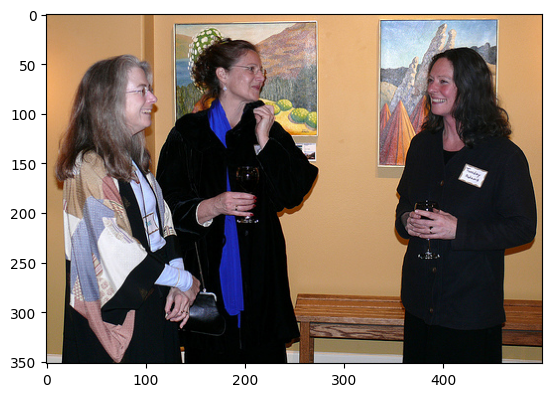

In [29]:
generate_caption("3271252073_0a1b9525fc.jpg")

---------------------Actual---------------------
startseq man is standing in front of brick storefront wearing black jacket endseq
startseq man standing on city street endseq
startseq the man is in front of building endseq
startseq young man in warm coat outside storefront endseq
startseq young man with cap and buttoned coat stands before building endseq
--------------------Predicted--------------------
startseq man wearing black jacket and glasses is standing in front of brick building endseq


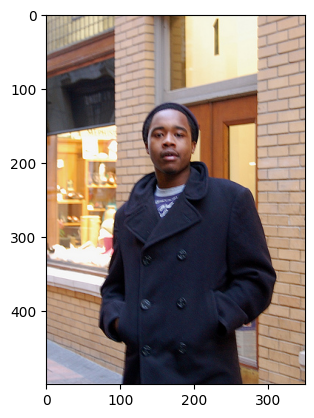

In [30]:
generate_caption("3293751640_d81a6f3a0c.jpg")

---------------------Actual---------------------
startseq person in green feathered costume is bending down in front of woman with painted breasts endseq
startseq woman in green costume is standing in front of topless woman with painted breasts endseq
startseq people in costumes are walking around in the street endseq
startseq two people dressed in green and red costumes are outside on the sidewalk endseq
startseq two people in lavish costumes standing on the street endseq
--------------------Predicted--------------------
startseq woman in red tank top and tank top is standing in front of large building endseq


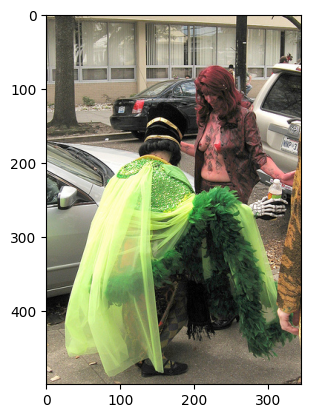

In [31]:
generate_caption("3342272425_804316cb3d.jpg")

## Test with Real Image

In [32]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [33]:
# image_path = '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'
image_path = '/kaggle/input/test-img/pexels-photo-3605139.jpeg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq snowmobiler in the air endseq'